In [1]:
import pandas as pd

In [2]:
df = pd.read_excel('../../data/raw/HISTORICO_SUERTES.xlsx')

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df['TCH'] = pd.to_numeric(df['TCH'], errors='coerce')
df['%Sac.Caña'] = pd.to_numeric(df['%Sac.Caña'], errors='coerce')
df.dropna(subset=['TCH', '%Sac.Caña'], inplace=True)

In [6]:
# Identificar todas las variables predictoras
leaks = ['Ton.Azucar', 'Rdto', 'TAH', 'TAHM', 'TonUltCorte', '%Sac.Muestreadora', '%ATR']
ids = ['Hacienda', 'Nombre', 'Suerte', 'Período']
targets = ['TCH', '%Sac.Caña']
excluded_cols = leaks + ids + targets

features = [col for col in df.columns if col not in excluded_cols]

In [7]:
# Separar por tipo de dato
numeric_features = df[features].select_dtypes(include=np.number).columns.tolist()
categorical_features = df[features].select_dtypes(exclude=np.number).columns.tolist()


In [8]:
# Convertir columnas objeto que deberían ser numéricas
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='ignore')


C:\Users\Pipicano\AppData\Local\Temp\ipykernel_7832\1666081778.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='ignore')
C:\Users\Pipicano\AppData\Local\Temp\ipykernel_7832\1666081778.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='ignore')
C:\Users\Pipicano\AppData\Local\Temp\ipykernel_7832\1666081778.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='ignore')
C:\Users\Pipicano\AppData\Local\Temp\ipykernel_7832\166

In [9]:
# Re-identificar tipos después de la conversión
numeric_features = df[features].select_dtypes(include=np.number).columns.tolist()
categorical_features = df[features].select_dtypes(exclude=np.number).columns.tolist()


In [10]:
# Crear pipelines de preprocesamiento
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

# Combinar preprocesadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder='passthrough')

In [11]:
# Definir X e y
X = df[features]
y_tch = df['TCH']
y_sac = df['%Sac.Caña']

In [12]:
# División de datos (Holdout)
X_train, X_test, y_tch_train, y_tch_test = train_test_split(X, y_tch, test_size=0.2, random_state=42)
_, _, y_sac_train, y_sac_test = train_test_split(X, y_sac, test_size=0.2, random_state=42)

In [13]:
# Modelos a evaluar
models = {
    "Ridge (L2)": Ridge(alpha=1.0),
    "Lasso (L1)": Lasso(alpha=0.1) # Un alpha pequeño para empezar
}

In [14]:
results = {}

print("--- Evaluando Modelos para TCH (Productividad) ---")
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    pipeline.fit(X_train, y_tch_train)
    y_pred = pipeline.predict(X_test)
    results[name] = [r2_score(y_tch_test, y_pred), np.sqrt(mean_squared_error(y_tch_test, y_pred)), mean_absolute_error(y_tch_test, y_pred)]

results_tch_df = pd.DataFrame(results, index=['R²', 'RMSE', 'MAE']).T
print(results_tch_df)

--- Evaluando Modelos para TCH (Productividad) ---


c:\Users\Pipicano\Music\Semester I\Prediccion-Clasificacion-Industria-Azucarera-ICESI\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['Fert.Nitrogen.' 'Sum Oscilacion Temp Ciclo']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Pipicano\Music\Semester I\Prediccion-Clasificacion-Industria-Azucarera-ICESI\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['Fert.Nitrogen.' 'Sum Oscilacion Temp Ciclo']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Pipicano\Music\Semester I\Prediccion-Clasificacion-Industria-Azucarera-ICESI\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['Fert.Nitrogen.' 'Sum Oscilacion Temp Ciclo']. At least one non-missing value is needed for imputation with stra

                  R²      RMSE       MAE
Ridge (L2)  0.965604  6.077361  3.776893
Lasso (L1)  0.968740  5.793661  3.102117


In [15]:
print("\n--- Evaluando Modelos para %Sac.Caña (Calidad) ---")
results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    pipeline.fit(X_train, y_sac_train)
    y_pred = pipeline.predict(X_test)
    results[name] = [r2_score(y_sac_test, y_pred), np.sqrt(mean_squared_error(y_sac_test, y_pred)), mean_absolute_error(y_sac_test, y_pred)]

results_sac_df = pd.DataFrame(results, index=['R²', 'RMSE', 'MAE']).T
print(results_sac_df)


--- Evaluando Modelos para %Sac.Caña (Calidad) ---


c:\Users\Pipicano\Music\Semester I\Prediccion-Clasificacion-Industria-Azucarera-ICESI\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['Fert.Nitrogen.' 'Sum Oscilacion Temp Ciclo']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Pipicano\Music\Semester I\Prediccion-Clasificacion-Industria-Azucarera-ICESI\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['Fert.Nitrogen.' 'Sum Oscilacion Temp Ciclo']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Pipicano\Music\Semester I\Prediccion-Clasificacion-Industria-Azucarera-ICESI\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['Fert.Nitrogen.' 'Sum Oscilacion Temp Ciclo']. At least one non-missing value is needed for imputation with stra

                  R²      RMSE       MAE
Ridge (L2)  0.814666  0.496309  0.319189
Lasso (L1)  0.490430  0.822956  0.634092


In [16]:
# Re-entrenar el pipeline de Lasso para TCH en todo el set de entrenamiento
lasso_tch_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', Lasso(alpha=0.1))])
lasso_tch_pipeline.fit(X_train, y_tch_train)

c:\Users\Pipicano\Music\Semester I\Prediccion-Clasificacion-Industria-Azucarera-ICESI\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['Fert.Nitrogen.' 'Sum Oscilacion Temp Ciclo']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [20]:
# Re-entrenar el pipeline de Lasso para TCH en todo el set de entrenamiento
lasso_tch_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', Lasso(alpha=0.1))])
lasso_tch_pipeline.fit(X_train, y_tch_train)

# Extraer los nombres de las características post-procesamiento
cat_feature_names = lasso_tch_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(cat_feature_names)

# Obtener los coeficientes
coefficients = lasso_tch_pipeline.named_steps['regressor'].coef_
lasso_coeffs = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': coefficients})

# Filtrar coeficientes que no son cero y ordenarlos
important_coeffs = lasso_coeffs[lasso_coeffs['Coefficient'] != 0].sort_values(by='Coefficient', ascending=False)

# Visualizar los 15 coeficientes más importantes (positivos y negativos)
top_coeffs = pd.concat([important_coeffs.head(10), important_coeffs.tail(10)]).sort_values('Coefficient', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='Coefficient', y='Feature', data=top_coeffs)
plt.title('Importancia de Variables para TCH según Coeficientes de Lasso (L1)')
plt.xlabel('Valor del Coeficiente')
plt.ylabel('Variable')
plt.show()

c:\Users\Pipicano\Music\Semester I\Prediccion-Clasificacion-Industria-Azucarera-ICESI\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['Fert.Nitrogen.' 'Sum Oscilacion Temp Ciclo']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


ValueError: All arrays must be of the same length

c:\Users\Pipicano\Music\Semester I\Prediccion-Clasificacion-Industria-Azucarera-ICESI\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['Fert.Nitrogen.' 'Sum Oscilacion Temp Ciclo']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Pipicano\Music\Semester I\Prediccion-Clasificacion-Industria-Azucarera-ICESI\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['Fert.Nitrogen.' 'Sum Oscilacion Temp Ciclo']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


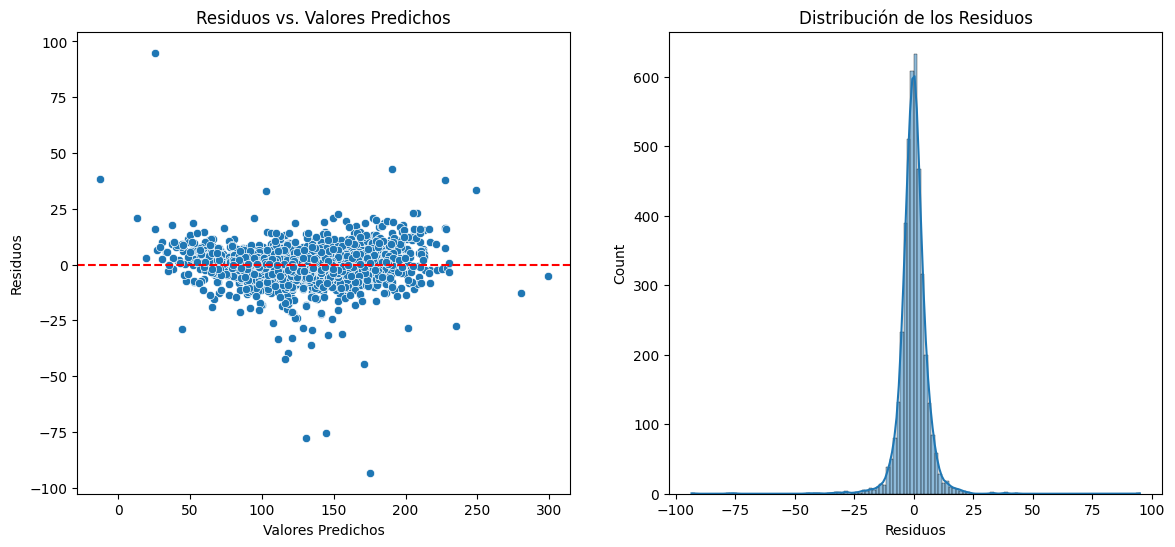

In [21]:
# Obtener predicciones del modelo Ridge para el diagnóstico
ridge_tch_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', Ridge(alpha=1.0))])
ridge_tch_pipeline.fit(X_train, y_tch_train)
y_pred_diag = ridge_tch_pipeline.predict(X_test)
residuals = y_tch_test - y_pred_diag

# Gráfico de Residuos vs. Valores Predichos (Homocedasticidad)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_diag, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuos vs. Valores Predichos')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')

# Histograma de Residuos (Normalidad)
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.title('Distribución de los Residuos')
plt.xlabel('Residuos')
plt.show()
